In [26]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoProcessor
from transformers import AutoProcessor, LlavaForConditionalGeneration
from IPython.display import display

In [20]:
def build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                 split='test',
                                 keep_grades='1-6'):
    """
    构建按年级过滤的测试数据集（不限制样本数量）。

    参数:
        dataset_name (str): 数据集名称，例如 'derek-thomas/ScienceQA'。
        split (str): 数据分割，例如 'train', 'test', 'validation'。
        keep_grades (str or None): 筛选的年级段："1-6"、"7-12" 或 None 表示不过滤。

    返回:
        List[Dict]: 筛选后的样本列表。
    """

    def is_grade_allowed(grade_str):
        if keep_grades is None:
            return True
        try:
            grade_num = int(grade_str.replace("grade", ""))
            if keep_grades == "1-6":
                return 1 <= grade_num <= 6
            elif keep_grades == "7-12":
                return 7 <= grade_num <= 12
        except:
            return False
        return False

    data = load_dataset(dataset_name, split=split)
    test_dataset = []

    for i, sample in enumerate(data):
        try:
            if sample.get('question') is None:
                continue

            if not is_grade_allowed(sample.get("grade", "")):
                continue

            solution = sample.get("solution", "")
            lecture = sample.get("lecture", "")
            solution_lecture = f"{solution}\n\n{lecture}".strip()

            test_dataset.append({
                "image": sample.get("image", None), 
                "question": sample["question"],
                "choices": sample["choices"],
                "hint": sample["hint"],
                "answer": sample["answer"],
                "solution_lecture": solution_lecture,
                'grade':sample["grade"],
            })

        except Exception as e:
            print(f"跳过第 {i} 个样本，错误：{e}")
            continue

    return test_dataset

In [22]:
test_dataset = build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                    split='validation',
                                    keep_grades='1-6')

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=202x202 at 0x7FD89C102E00>, 'question': "Which animal's mouth is also adapted for bottom feeding?", 'choices': ['discus', 'armored catfish'], 'hint': "Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.\nThe 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\nFigure: sturgeon.", 'answer': 1, 'solution_lecture': "Look at the picture of the sturgeon.\nThe sturgeon's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding. The sturgeon uses its mouth to find food hidden in the sediment at the bottom of rivers, lakes, and the ocean.\nNow look at each animal. Figure out which animal has a similar adaptation.\nThe armored catfish's mouth is located on the underside of its head and points downward. Its mouth is adapted 

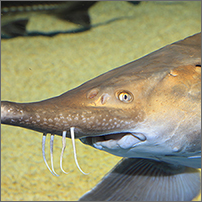

In [28]:
print (test_dataset[0])
display(test_dataset[0]["image"])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

Using device: cuda


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [15]:
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": sample['image']})
    
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    
    if sample.get("hint"):
        question_text += f"\nHint: {sample['hint']}\n"
    
    question_text += "Please select the correct answer and explain why."
    content.append({"type": "text", "text": question_text})
    
    return [{"role": "user", "content": content}]


In [24]:
build_message(test_dataset[0])

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=202x202>},
   {'type': 'text',
    'text': "Question: Which animal's mouth is also adapted for bottom feeding?\nChoices:\nA. discus\nB. armored catfish\n\nHint: Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean.\nThe 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding.\nFigure: sturgeon.\nPlease select the correct answer and explain why."}]}]

In [ ]:
# 解析模型输出中的选项字母
def parse_output(output):
    output = output.strip()
    answer_match = re.search(r"\b([A-D])[\.\:]", output)
    if answer_match:
        answer = ord(answer_match.group(1)) - 65
    else:
        answer = -1
    explanation = ""
    if answer != -1:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()
    return answer, explanation

# 初始化工具
rouge = Rouge()
smoothie = SmoothingFunction().method1
vectorizer = CountVectorizer(stop_words="english").fit([s["solution_lecture"] for s in test_dataset])
keywords = set(vectorizer.get_feature_names_out())

# 开始评估
all_records = []

for sample in tqdm(test_dataset[:2]):
    messages = build_message(sample)
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs = [sample["image"]] if sample["image"] else None

    inputs = processor(text=[text], images=image_inputs, return_tensors="pt", padding=True).to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=512)
    output = processor.batch_decode(generated_ids[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]

    pred_answer, pred_explanation = parse_output(output)
    true_answer = sample["answer"]

    # BLEU-1 和 BLEU-4
    reference = sample["solution_lecture"].split()
    hypothesis = pred_explanation.split()
    bleu1 = sentence_bleu([reference], hypothesis, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu([reference], hypothesis, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    # ROUGE-L
    try:
        rouge_score = rouge.get_scores(pred_explanation, sample["solution_lecture"])[0]["rouge-l"]["f"]
    except:
        rouge_score = 0.0

    # 关键词重叠
    gt_tokens = set(sample["solution_lecture"].lower().split())
    pred_tokens = set(pred_explanation.lower().split())
    overlap = len(gt_tokens & pred_tokens & keywords)
    keyword_score = overlap / max(len(gt_tokens & keywords), 1)

    all_records.append({
        "Question": sample["question"],
        "Choices": "\n".join(sample["choices"]),
        "True Answer": true_answer,
        "Predicted Answer": pred_answer,
        "Predicted Answer Text": sample["choices"][pred_answer] if 0 <= pred_answer < len(sample["choices"]) else "N/A",
        "Model Output": output,
        "Model Explanation": pred_explanation,
        "Reference Solution": sample["solution_lecture"],
        "BLEU-1": bleu1,
        "BLEU-4": bleu4,
        "ROUGE-L": rouge_score,
        "Keyword Overlap": keyword_score
    })

# 结果表格
results_df = pd.DataFrame(all_records)

# 汇总评估
acc = accuracy_score(results_df["True Answer"], results_df["Predicted Answer"])
f1 = f1_score(results_df["True Answer"], results_df["Predicted Answer"], average='macro')
avg_bleu1 = results_df["BLEU-1"].mean()
avg_bleu4 = results_df["BLEU-4"].mean()
avg_rouge = results_df["ROUGE-L"].mean()
avg_keyword_overlap = results_df["Keyword Overlap"].mean()

# 打印汇总结果
print("\nSummary Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Avg BLEU-1: {avg_bleu1:.4f}")
print(f"Avg BLEU-4: {avg_bleu4:.4f}")
print(f"Avg ROUGE-L: {avg_rouge:.4f}")
print(f"Avg Keyword Overlap: {avg_keyword_overlap:.4f}")

# 保存为 CSV
results_df.to_csv("llava_evaluation_results_scienceQA.csv", index=False)
print("\n✅ 结果已保存为 llava_evaluation_results_scienceQA.csv")


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Summary Metrics:
Accuracy: 0.5000
F1 Score: 0.3333
Avg BLEU-1: 0.0000
Avg BLEU-4: 0.0000
Avg ROUGE-L: 0.0102
Avg Keyword Overlap: 0.0122

✅ 结果已保存为 model_evaluation_results.csv
